In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tcn import TCN


In [2]:
datasets = joblib.load("all_pollutant_datasets.pkl")

POLLUTANTS = ["PM25", "PM10", "NO2", "SO2", "O3", "CO", "NOX"]


In [3]:
from pandas.tseries.offsets import DateOffset

def temporal_split(df):
    last_date = df["datetime"].max()
    test_start = last_date - DateOffset(months=6)
    val_start  = test_start - DateOffset(months=6)

    train = df[df["datetime"] < val_start]
    val   = df[(df["datetime"] >= val_start) & (df["datetime"] < test_start)]
    test  = df[df["datetime"] >= test_start]

    return train, val, test


In [4]:
BASE_FEATURES = [
    "lat", "lon",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "month", "is_weekend",
    "u", "v",
    "AT", "RH", "BP", "SolarRad", "Rain"
]

def get_feature_columns(df, target):
    lag_features = [
        c for c in df.columns
        if c.startswith(target+"_") or
           any(c.startswith(x+"_") for x in ["WS", "AT", "RH", "BP"])
    ]
    return BASE_FEATURES + lag_features


In [5]:
def scale_features(train, val, test, feature_cols):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[feature_cols])
    X_val   = scaler.transform(val[feature_cols])
    X_test  = scaler.transform(test[feature_cols])
    return X_train, X_val, X_test, scaler


In [6]:
def create_sequences(X, y, timesteps=24):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X[i-timesteps:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)


Hybrid Model Definition

In [7]:
def build_hybrid(input_shape):
    inp = Input(shape=input_shape)

    x = TCN(
        nb_filters=64,
        kernel_size=3,
        dilations=[1, 2, 4, 8, 16],
        dropout_rate=0.2,
        return_sequences=True,
    )(inp)

    x = LSTM(64)(x)

    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(
        optimizer=Adam(0.001),
        loss="mse",
        metrics=["mae"]
    )
    return model


Evaluation Function

In [8]:
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2


Training

In [10]:
results = {}
predictions = {}

for target in POLLUTANTS:
    print(f"\n===== Training Hybrid TCN + LSTM for {target} =====")

    df = datasets[target]
    features = get_feature_columns(df, target)

    train, val, test = temporal_split(df)

    X_train, X_val, X_test, scaler = scale_features(train, val, test, features)
    y_train, y_val, y_test = train[target], val[target], test[target]

    X_train_seq, y_train_seq = create_sequences(X_train, y_train)
    X_val_seq, y_val_seq     = create_sequences(X_val, y_val)
    X_test_seq, y_test_seq   = create_sequences(X_test, y_test)

    model = build_hybrid((X_train_seq.shape[1], X_train_seq.shape[2]))

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=40,
        batch_size=128,
        callbacks=[EarlyStopping(patience=6, restore_best_weights=True)],
        verbose=1
    )

    preds = model.predict(X_test_seq).ravel()

    rmse, mae, r2 = evaluate(y_test_seq, preds)

    print(f"{target} → RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

    results[target] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    predictions[target] = (y_test_seq, preds)


===== Training Hybrid TCN + LSTM for PM25 =====
Epoch 1/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 330.0758 - mae: 12.1689 - val_loss: 109.8382 - val_mae: 7.6590
Epoch 2/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 243.4051 - mae: 10.6989 - val_loss: 115.8756 - val_mae: 8.5692
Epoch 3/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 232.0853 - mae: 10.9210 - val_loss: 124.8126 - val_mae: 9.1586
Epoch 4/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 204.3651 - mae: 9.7217 - val_loss: 83.2479 - val_mae: 6.6387
Epoch 5/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 154.9426 - mae: 8.0104 - val_loss: 66.0918 - val_mae: 5.6491
Epoch 6/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 125.0763 - mae: 6.9900 - val_loss: 58.1833 - val_mae: 5.1272
Epoch 7/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 107.4142 - mae: 6.4224 - val_loss: 49.2812 - val_mae: 4.7608
Epoch 8/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 96.1774 - mae: 6.11

In [11]:
print("\n===== Hybrid Performance Summary =====")
for pol, m in results.items():
    print(f"{pol}: RMSE={m['RMSE']:.3f}, MAE={m['MAE']:.3f}, R²={m['R2']:.3f}")



===== Hybrid Performance Summary =====
PM25: RMSE=6.039, MAE=4.484, R²=0.775
PM10: RMSE=11.869, MAE=8.568, R²=0.695
NO2: RMSE=4.170, MAE=2.975, R²=0.732
SO2: RMSE=0.786, MAE=0.664, R²=0.071
O3: RMSE=5.077, MAE=3.615, R²=0.761
CO: RMSE=352.682, MAE=241.679, R²=-0.346
NOX: RMSE=9.368, MAE=6.323, R²=0.667


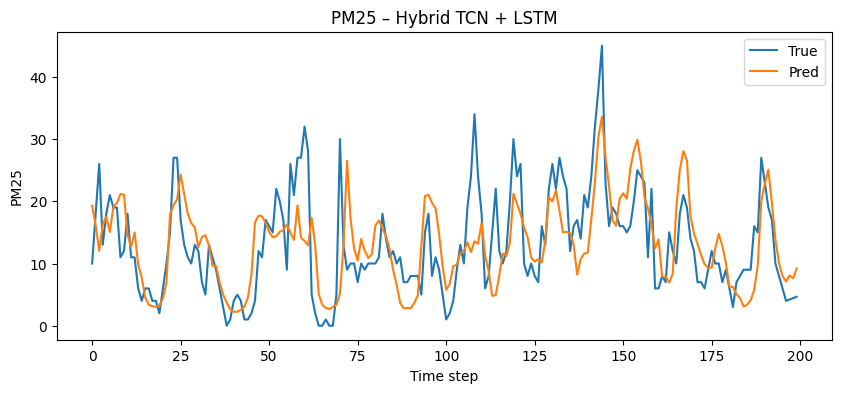

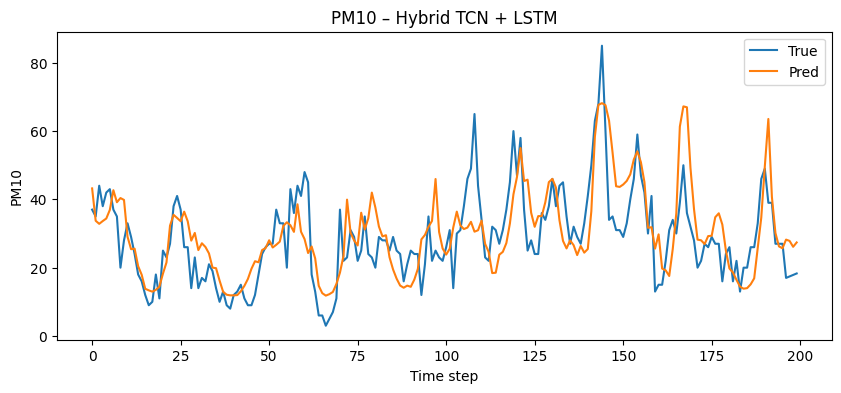

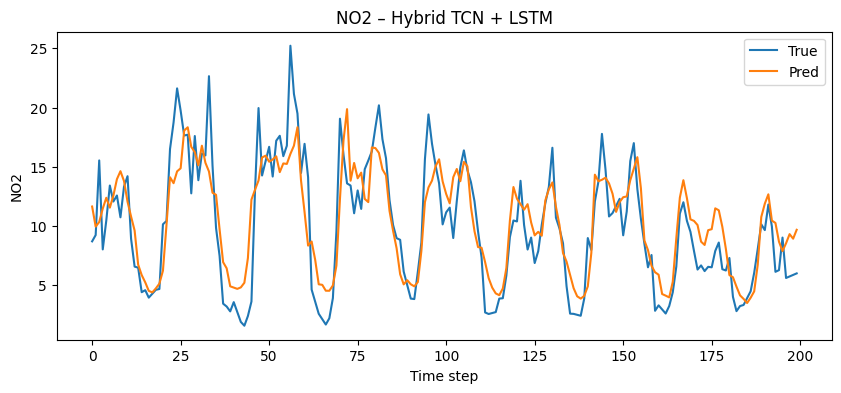

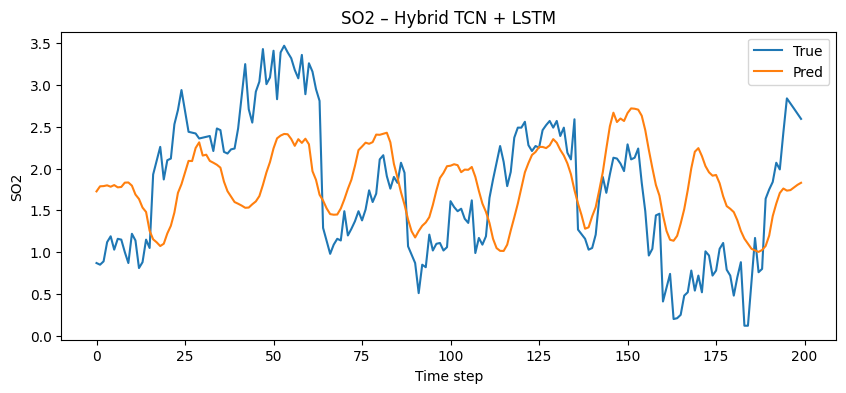

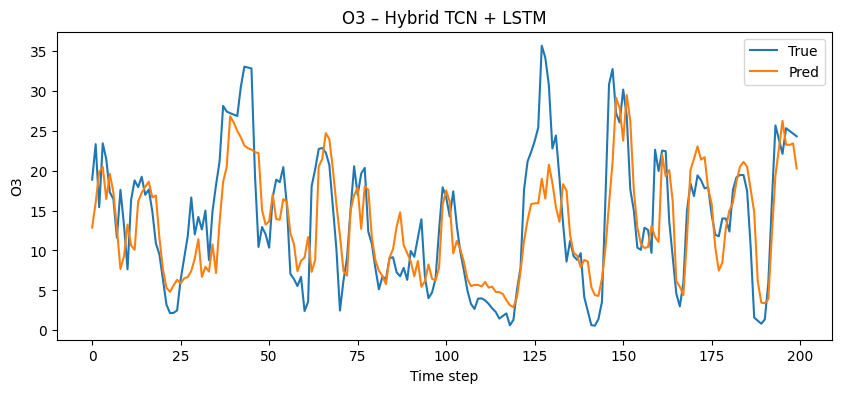

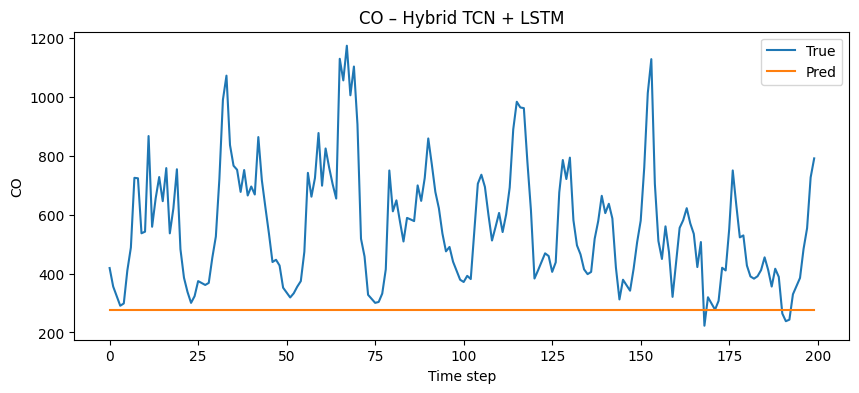

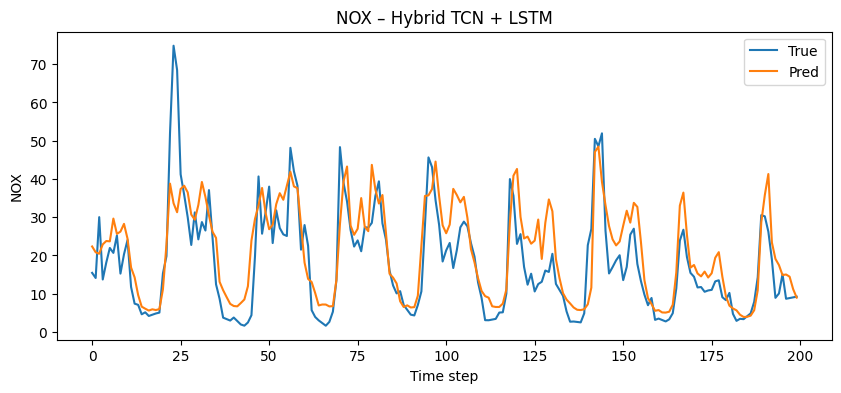

In [12]:
for pol in POLLUTANTS:
    y_true, y_pred = predictions[pol]

    plt.figure(figsize=(10,4))
    plt.plot(y_true[:200], label="True")
    plt.plot(y_pred[:200], label="Pred")
    plt.title(f"{pol} – Hybrid TCN + LSTM")
    plt.xlabel("Time step")
    plt.ylabel(pol)
    plt.legend()
    plt.show()
